In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import json
import os
import collections
import torch
from torch import optim
from torch import nn
import models
from models import AverageMeter
import torch_utils

## Loading data

In [2]:
DATA_DIR = "./data/cases_small_preprocessedLEMM_vectorized"

In [17]:
X_train = torch.from_numpy(np.load(os.path.join(DATA_DIR, "x_train.npy")))
X_test = torch.from_numpy(np.load(os.path.join(DATA_DIR, "x_test.npy")))
Y_train = torch.from_numpy(np.load(os.path.join(DATA_DIR, "y_train.npy")))
Y_test = torch.from_numpy(np.load(os.path.join(DATA_DIR, "y_test.npy")))
word_index = json.load(open(os.path.join(DATA_DIR, "word_index.json"), 'r'))

In [18]:
TOP_K = 20000
EMB_DIM = 200
MAX_L = 100
OUT_CHANNELS = 2**6  # n filters
KERNEL_SIZE = 4
POOL_SIZE = 2
N_BLOCKS=3
DROPOUT_RATE=0.2
num_features = min(len(word_index) + 1, TOP_K)


INPUT_DIM = X_train.shape[-1]
print(f'INPUT_DIM : {INPUT_DIM}')
OUTPUT_DIM = len(np.unique(Y_train))  # _classes
print(f'OUTPUT_DIM : {OUTPUT_DIM}')

BATCH_SIZE = 2**7
print(f'BATCH_SIZE : {BATCH_SIZE}')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

print(DEVICE)

model = models.SepConvModel(
    out_channels=OUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    pool_size=POOL_SIZE,
    n_blocks=N_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    embedding_dim=EMB_DIM,
    output_dim=OUTPUT_DIM,
    num_embeddings=num_features
)

model.to(DEVICE)
HISTORY = collections.defaultdict(list)

N_BATCHES_train = X_train.shape[0] // BATCH_SIZE + int(X_train.shape[0] % BATCH_SIZE != 0)
print(f"Number of updates per epoch:: {N_BATCHES_train}")

X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)
Y_train = Y_train.to(DEVICE)
Y_test = Y_test.to(DEVICE)

INPUT_DIM : 1024
OUTPUT_DIM : 36
BATCH_SIZE : 128
cuda:0
Number of updates per epoch:: 814


In [19]:
# optimizer = optim.Adam(model.parameters(), lr=1e-3/2, weight_decay=0.0004)
optimizer = optim.Adam(model.parameters(), lr=1e-3, 
#                        weight_decay=0.0001
                      )

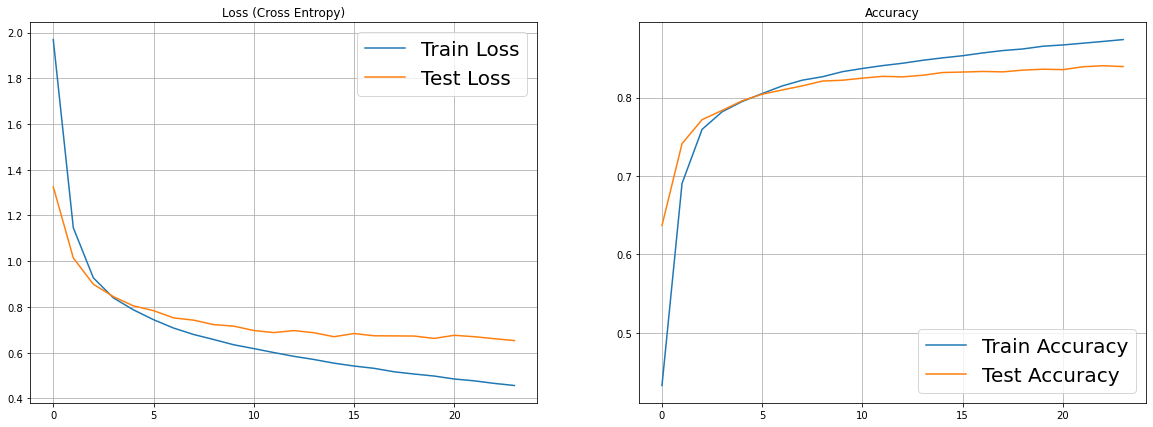

In [ ]:
NUM_EPOCH = 100
criterion = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCH):
    
    criterion = nn.CrossEntropyLoss()

    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()


    for train_batch in  torch_utils.dataloader(X_train, Y_train, BATCH_SIZE):


        x, labels = train_batch

        logits = model.forward(x)
        prediction = torch.argmax(logits, 1)
        loss = criterion(logits, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        acc = torch_utils.calculate_accuracy(prediction, labels)
        train_loss_meter.update(loss)
        train_accuracy_meter.update(acc)


    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)


    for test_batch in torch_utils.dataloader(X_test, Y_test, BATCH_SIZE):
        x, labels = test_batch
        with torch.no_grad():
            logits = model.forward(x)
            prediction = torch.argmax(logits, 1)
            loss = criterion(logits, labels)

        acc = torch_utils.calculate_accuracy(prediction, labels)
        test_loss_meter.update(loss)
        test_accuracy_meter.update(acc)

    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)


    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)

    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)

    plt.show()

In [16]:
max(HISTORY['test_accuracy'])

tensor(0.8533, device='cuda:0')